In [1]:
import os
os.chdir('..')

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import models
import scoring
from data import pronostia
import gc 
import pickle as pk
import pandas as pd

In [3]:
import pickle as pk

results = {}
results['cnn_rnn_rna'] = pk.load(open('../results/predictions/pronostia/cnn_rnn_rna.pk', 'rb'))
results['cnn_cnn_rna'] = pk.load(open('../results/predictions/pronostia/cnn_cnn_rna.pk', 'rb'))
results['rnn_rnn_rna'] = pk.load(open('../results/predictions/pronostia/rnn_rnn_rna.pk', 'rb'))
results['rnn_cnn_rna'] = pk.load(open('../results/predictions/pronostia/rnn_cnn_rna.pk', 'rb'))
results['cnn_fen'] = pk.load(open('../results/predictions/pronostia/cnn_fen.pk', 'rb'))
results['rnn_fen'] = pk.load(open('../results/predictions/pronostia/rnn_fen.pk', 'rb'))


colors = {
    'cnn_rnn_rna': '#dc4048',
    'cnn_cnn_rna':'#fca311',
    'rnn_cnn_rna':'#2a9d8f',
    'rnn_rnn_rna':'#7acdf1',
    'rnn_fen':'#003f6b', 
    'cnn_fen':'#ffc6ff',
}


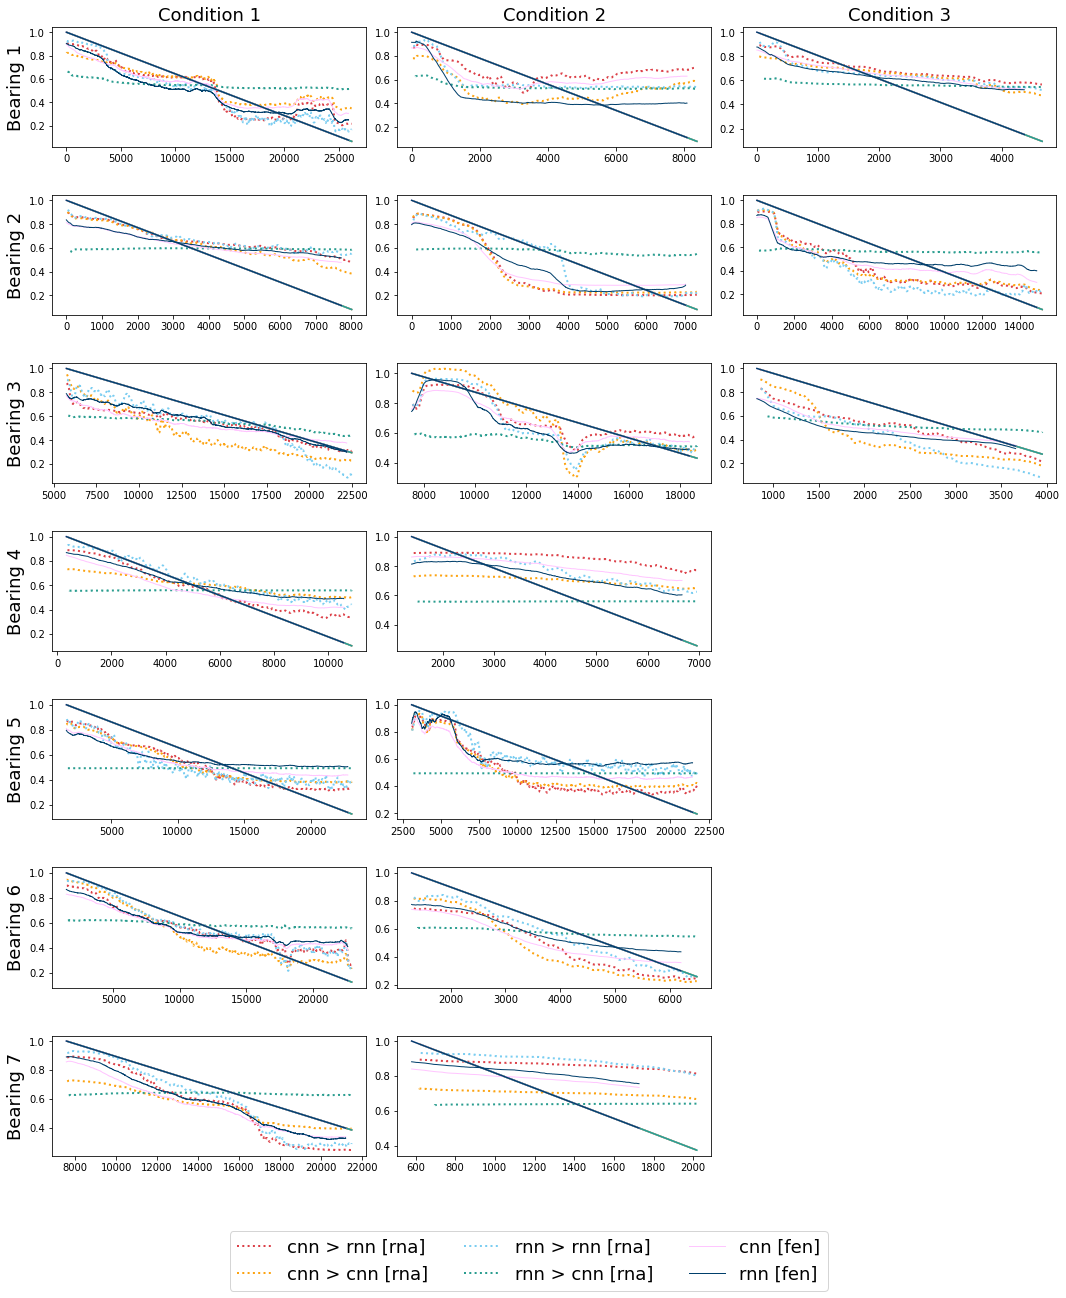

In [53]:
MAX_RULS = {(3, 1): 23749,
 (3, 2): 19549,
 (3, 3): 4339,
 (4, 1): 11728,
 (4, 2): 7509,
 (5, 1): 24629,
 (5, 2): 23109,
 (6, 1): 24479,
 (6, 2): 7009,
 (7, 1): 22589,
 (7, 2): 2299,
 (1, 1): 28029,
 (1, 2): 9109,
 (1, 3): 5149,
 (2, 1): 8709,
 (2, 2): 7969,
 (2, 3): 16369
}


def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def process_predictions(results, bearing, condition):
    dbc = [d for d in results if d['bearing'] == bearing and d['condition'] == condition]
    
    l = [len(d['pred']) for d in dbc]
    assert [l[0] == e for e in l]
    
    pred = [d['pred'] for d in dbc]
    pred = np.array(pred).mean(axis=0)
    
    t = [d['t'] for d in dbc]
    t = np.array(t).mean(axis=0)
    
    rul = [d['rul'] for d in dbc]
    rul = np.array(rul).mean(axis=0)
    
    #pred = pred[:t.shape[0]-1]
    #t = t[:pred.shape[0]-1]
    
    maw = 500
    if maw > 1:
        pred = moving_average(pred, maw)
    
    #assert len(pred) == len(dbc[0]['t'][101:])
    
    return pred, rul[:-maw+1], t[:-maw+1]


errors = {}

plt.rcParams['figure.figsize'] = [12, 8]

key = list(results.keys())[0]
bearings = sorted(set([(r['bearing'], r['condition']) 
                       for r in results[key]]), 
                  key=lambda b: b[0]*100 + b[1])


fig, axs = plt.subplots(7, 3, figsize=(18, 16))
    

for i in range(3,7):
    axs[i, 2].set_visible(False)
    
thresold_ratio = 0.06
for bearing, condition in bearings:
    
    ax = axs[bearing-1, condition-1]
    
    preds = {}
    ruls = {}
    for k, (key, result) in enumerate(results.items()):
        pred, rul, t_ = process_predictions(result, bearing, condition)
        preds[key] = pred
        ruls[key] = rul
        
        thresold = int(pred.shape[0] * thresold_ratio)
        pred = pred[:-thresold]
        rul = rul[:-thresold]
        t_ = t_[:-thresold]
        
        label = key.split('_')
        if len(label) == 2:
            label = f"{label[0]} [{label[1]}]"
        else:
            label = f"{label[0]} > {label[1]} [{label[2]}]"
       
        ax.plot(t_, pred, ':' if 'rna' in key else '-', 
                label=label,
                linewidth=2 if 'rna' in key else 1, 
                markersize=1, c=colors[key])
        
        ax.plot(t_, rul, c=colors[key])
        
        if key=='cnn_fna':
            rul = dbc[0]['rul'][-pred.shape[0]:]
            t = t_
    
    if bearing == 1:
        ax.set_title(f"Condition {condition}", fontsize=18)
        
    if condition == 1:
        ax.set_ylabel(f"Bearing {bearing}", fontsize=18)
    
   
    if bearing == 7 and condition == 2:
        ax.legend(ncol=3, loc=4, fontsize=18, bbox_to_anchor=(0.9, -1.2, 0.5, 0.5))

    
    #print(bearing, condition, error) #, len(d), np.min(dbc[0]['rul']), error)

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=.1)
plt.savefig('pronostia_charts.svg')
plt.show() 

In [54]:
MAX_RULS = {(3, 1): 23749,
 (3, 2): 19549,
 (3, 3): 4339,
 (4, 1): 11728,
 (4, 2): 7509,
 (5, 1): 24629,
 (5, 2): 23109,
 (6, 1): 24479,
 (6, 2): 7009,
 (7, 1): 22589,
 (7, 2): 2299,
 (1, 1): 28029,
 (1, 2): 9109,
 (1, 3): 5149,
 (2, 1): 8709,
 (2, 2): 7969,
 (2, 3): 16369
}


errors = {}
thresold_ratio = 0.06
import pandas as pd

for key, data in results.items():
    if key in errors:
        continue
        
    print(key)
        
    model_errors = []
    _ids = set([(d['bearing'], d['condition']) for d in data])
    #print(_ids)
    for bearing, condition in _ids:
                    
        _data = [d for d in data if d['bearing'] == bearing and d['condition'] == condition]
        y_pred = np.mean([d['pred'] for d in _data], axis=0)
        y_true = np.mean([np.array(d['rul']) for d in _data], axis=0)
        
        if len(y_pred.shape) == 2:
            y_pred = y_pred[:, 0]
            
        #if y_pred.shape[0] > thresold:
        thresold = int(y_pred.shape[0] * thresold_ratio)
        y_pred = y_pred[:-thresold]
        y_true = y_true[:-thresold]
        
        y_true_unnorm = (y_true) * MAX_RULS[(bearing,condition)]
        y_pred_unnorm = (y_pred) * MAX_RULS[(bearing,condition)]
        

        nasa_scoring = scoring.NASAScore()
        nasa_scoring.update_state(y_true, y_pred)
        dif = y_pred - y_true
        dif_sq = dif ** 2
        mse = np.mean(dif_sq)
        model_errors.append({
            "mse": mse,
            "rmse": np.sqrt(mse),
            "mae": np.mean(abs(dif)),
            "nasa": np.mean(nasa_scoring.result()),
            "mape": np.mean(100 * np.abs(y_true_unnorm -  y_pred_unnorm) / (y_true_unnorm + 1)),

        })
        
        
    errors[key] = pd.DataFrame(model_errors).mean().to_dict()
    
    
x = []
for key, errs in errors.items():
    
    for metric, value in errs.items():
        err = {}
        err['metric'] = metric
        err['value'] = f"{np.mean(value):05.2f}"
        net = key.split('_')

        err['level'] = net[-1]
        err['net'] = net[0]
        if len(net) == 3:
            err['net'] = '-'.join(net[:2])

        #print(key, errs)
        x.append(err)
        
        
table_results = pd.DataFrame(x).sort_values(['level', 'net']).pivot(index=['metric'], 
                                                    values='value', 
                                                    columns=['level', 'net'])

table_results
print(table_results.to_latex())

cnn_rnn_rna
cnn_cnn_rna
rnn_rnn_rna
rnn_cnn_rna
cnn_fen
rnn_fen
\begin{tabular}{lllllll}
\toprule
level & \multicolumn{2}{l}{fen} & \multicolumn{4}{l}{rna} \\
net &    cnn &    rnn & cnn-cnn & cnn-rnn & rnn-cnn & rnn-rnn \\
metric &        &        &         &         &         &         \\
\midrule
mae    &  00.15 &  00.15 &   00.15 &   00.14 &   00.20 &   00.14 \\
mape   &  43.56 &  43.15 &   41.35 &   41.50 &   56.96 &   40.48 \\
mse    &  00.03 &  00.03 &   00.03 &   00.03 &   00.05 &   00.03 \\
nasa   &  00.01 &  00.01 &   00.01 &   00.01 &   00.02 &   00.01 \\
rmse   &  00.18 &  00.18 &   00.18 &   00.17 &   00.23 &   00.16 \\
\bottomrule
\end{tabular}

